<a href="https://colab.research.google.com/github/PUC-RecSys-Class/RecSysPUC-2020/blob/master/practicos/pyRecLab_FunkSVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    174      0 --:--:--  0:00:02 --:--:--   174
100 1546k  100 1546k    0     0   640k      0  0:00:02  0:00:02 --:--:--  640k


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    369      0 --:--:--  0:00:01 --:--:--   369
100  385k  100  385k    0     0   314k      0  0:00:01  0:00:01 --:--:--  314k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1366      0 --:--:-- --:--:-- --:--:--  1366
100  230k  100  230k    0     0   500k      0 --:--:-- --:--:-- --:--:--  500k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip install pyreclab --upgrade
#!pip install seaborn --upgrade

     |████████████████████████████████| 234 kB 4.8 MB/s 


In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

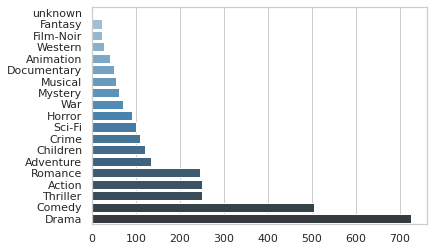

In [12]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:** 
SVD es la descomposición en valores singulares de una matriz A, en nuestro caso A es la matrix de ratings usersVSitems. Se usa, en train(), métodos iterativos (descenso de gradiente) para aproximar con mucho menor costo esta descomposición, usando además regularizadores para evitar overfitting, hay que explicitar el número de factores latentes a usar, el número de iteraciones permitida, y los parámetros lambda y learning rate. 

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [13]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]
print(user_df.head())
df_items.loc[user_df['itemid'].values].head()

     userid  itemid  rating  timestamp
218       2      13       4  888551922
219       2      19       3  888550871
220       2      50       5  888552084
221       2     100       5  888552084
222       2     127       5  888552084


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [15]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7200437927792314
RMSE: 0.9143454324315524


In [16]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.11299075343435777
NDCG@20: 0.06342424177884935


In [17]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1512, 1449, 169, 1367, 408, 1558, 12, 963, 64, 1467, 1137, 318, 1398, 119, 483, 124, 187, 1064, 134, 1122]


In [18]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking].head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió: *COMPLETAR*

- Variando número de factores:

No hay mucha diferencia, lo cual es en principio esperable pues solo cambia la dimensionalidad del problema, ahora podria pasar que en verdad en esta nueva dimension hubieran elementos más cerca que en la antigua dimension.

In [51]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# Entrenamiento del modelo
svd.train(factors=300, maxiter=100, lr=0.01, lamb=0.1)  ## AQUI CAMBIAMOS factors

# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
print('Testing de predicciones \nMAE: {}\nRMSE: {}'.format(mae, rmse))

# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test', dlmchar=b'\t', 
                                          header=False, usercol=0, itemcol=1, 
                                          ratingcol=2, topn=top_n,
                                          relevance_threshold=2, includeRated=False)

print('Testing de recomendaciones \nMAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking].head()

Testing de predicciones 
MAE: 0.7202010654400698
RMSE: 0.9131685519373288
Testing de recomendaciones 
MAP: 0.13505826726702078
NDCG@20: 0.07755500268380017
Recommendation for user 2: [1512, 1449, 408, 169, 1367, 318, 480, 1467, 64, 483, 134, 12, 1500, 1642, 1558, 174, 1398, 513, 603, 1137]


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Variando número de iteraciones máximas:

Aqui permite que se siga optimizando la funcion de perdida lo que estaría obteniendo menor error

In [49]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# Entrenamiento del modelo
svd.train(factors=100, maxiter=200, lr=0.01, lamb=0.1) ## AQUI CAMBIAMOS maxiter

# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
print('Testing de predicciones \nMAE: {}\nRMSE: {}'.format(mae, rmse))

# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test', dlmchar=b'\t', 
                                          header=False, usercol=0, itemcol=1, 
                                          ratingcol=2, topn=top_n,
                                          relevance_threshold=2, includeRated=False)

print('Testing de recomendaciones \nMAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking].head()

MAE: 0.7213008082187212
RMSE: 0.9153441588285048
MAP: 0.09382265113365121
NDCG@20: 0.052968232804225523
Recommendation for user 2: [1450, 1512, 1398, 1449, 169, 963, 1500, 408, 64, 119, 480, 318, 483, 12, 1367, 134, 1467, 1137, 1064, 1558]


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1450,Golden Earrings (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Golden%20Earr...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1398,Anna (1996),13-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Anna%20(1996),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Variando learning rate:

Aqui al darle menor LR los "pasos de aprendizaje" son más largos, es más susceptible a "bailar" al rededor de un óptimo local si este es convexo

In [52]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.1, lamb=0.1) ## AQUI CAMBIAMOS maxiter

# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
print('Testing de predicciones \nMAE: {}\nRMSE: {}'.format(mae, rmse))

# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test', dlmchar=b'\t', 
                                          header=False, usercol=0, itemcol=1, 
                                          ratingcol=2, topn=top_n,
                                          relevance_threshold=2, includeRated=False)

print('Testing de recomendaciones \nMAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking].head()

Testing de predicciones 
MAE: 0.7645828721516412
RMSE: 0.96191842513044
Testing de recomendaciones 
MAP: 0.12167739797523995
NDCG@20: 0.058010891357371995
Recommendation for user 2: [1512, 1449, 169, 1064, 922, 1240, 187, 1558, 1122, 813, 136, 357, 1398, 318, 320, 1103, 1642, 1467, 98, 589]


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1064,Crossfire (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Crossfire%20(...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
922,Dead Man (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


variando lambda

In [53]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.5) ## AQUI CAMBIAMOS lamb

# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
print('Testing de predicciones \nMAE: {}\nRMSE: {}'.format(mae, rmse))

# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test', dlmchar=b'\t', 
                                          header=False, usercol=0, itemcol=1, 
                                          ratingcol=2, topn=top_n,
                                          relevance_threshold=2, includeRated=False)

print('Testing de recomendaciones \nMAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking].head()

Testing de predicciones 
MAE: 0.7748507097161466
RMSE: 0.9644021042352243
Testing de recomendaciones 
MAP: 0.015466015490229306
NDCG@20: 0.01019130852515775
Recommendation for user 2: [1512, 1467, 1500, 814, 1536, 1449, 1450, 1189, 1599, 1293, 1642, 1367, 1653, 1064, 1398, 408, 169, 318, 114, 1122]


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
814,"Great Day in Harlem, A (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Great%20Day%2...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Aiqing%20Wans...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [19]:
# Ejemplo
factor_values = [50,100, 150, 200,300,500] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7224843300494933, 0.720738696360906, 0.720560482351348, 0.7199292412438499, 0.7204947473453797, 0.7202898497374773]
[0.9170269317755252, 0.9144702020801118, 0.9145231169941316, 0.9133612186451511, 0.9137273911867642, 0.9130926631292692]


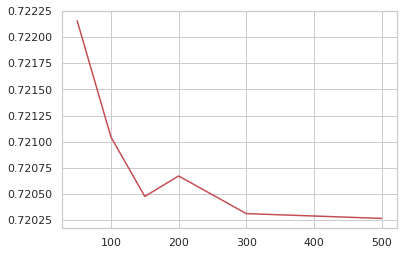

In [ ]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

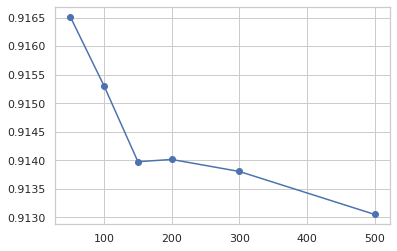

In [ ]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 8:** Pruebe con otros valores y/o parámetros:

[0.7224173453200827, 0.7218075170234468, 0.7215124732382409, 0.721407582915082, 0.7213022796584627, 0.7212466262250157]
[0.9174617580654847, 0.9157541640127981, 0.9153544507049634, 0.915322836255821, 0.9150345612911477, 0.914969010978218]


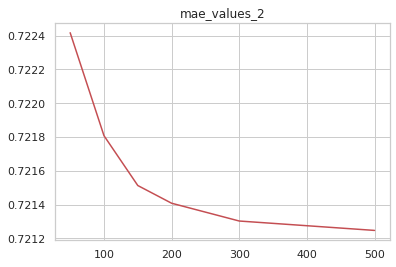

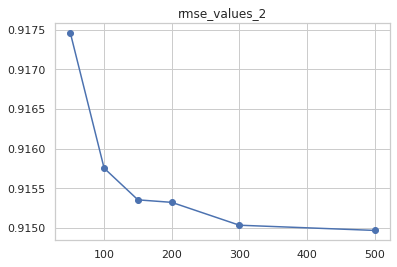

In [21]:
# Ejemplo
factor_values = [50,100, 150, 200,300,500] # definir distintos numeros de factores
mae_values_2 = [] # para almacenar resultados de MAP
rmse_values_2 = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=300, lr=0.01, lamb=0.1)
  predlist, mae, rmse = svd.test(input_file='u2.test', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
  mae_values_2.append(mae)
  rmse_values_2.append(rmse)

print(mae_values_2)
print(rmse_values_2)
plt.plot(factor_values, mae_values_2, 'r-')
plt.title("mae_values_2")
plt.show()
plt.plot(factor_values, rmse_values_2, 'bo-')
plt.title("rmse_values_2")
plt.show()

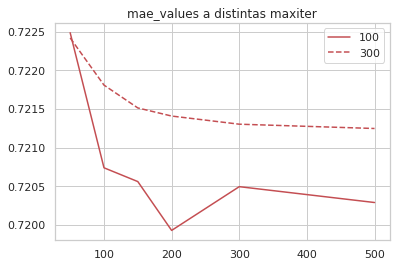

In [27]:
plt.plot(factor_values, mae_values, 'r-')
plt.plot(factor_values, mae_values_2, 'r--')
plt.legend([100,300])
plt.title("mae_values a distintas maxiter")
plt.show()

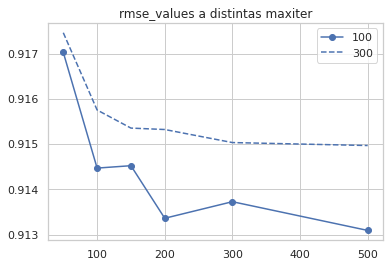

In [28]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.plot(factor_values, rmse_values_2, 'b--')
plt.legend([100,300])
plt.title("rmse_values a distintas maxiter")
plt.show()